In [1]:
import numpy as np
import pandas as pd
import psycopg as pg
import mlflow
import os
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt

In [2]:
TABLE_NAME = "clean_realestate_data"
TACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "Prev_linear_model"
RUN_NAME = "linear_model_init"
REGISTRY_MODEL_NAME = "Registered_Linear_model"

In [3]:
configs = {"sslmode": "require", "target_session_attrs": "read-write"}
db_credits = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD")
}

configs.update(db_credits)

In [4]:
with pg.connect(**configs) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")

        data = cur.fetchall()

        columns = [col.name for col in cur.description]

df = pd.DataFrame(data=data, columns=columns)

In [5]:
X = df.drop(columns=["id", "price"])
y = df["price"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
preprocess = ColumnTransformer(transformers=[
    ("numeric", StandardScaler(), X_train.columns.tolist())
],
remainder="drop",
verbose_feature_names_out=False)
model = LinearRegression()

In [8]:
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['build_year',
                                                   'building_type_int',
                                                   'latitude', 'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total',
                                                   'has_elevator', 'floor',
                                                   'is_apartment',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'studio', 'total_area'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [10]:
predictions =  pipeline.predict(X_test)

In [11]:
metrics = {}

In [12]:
r2 = r2_score(y_test, predictions)
metrics["r2"] = r2

In [13]:
mae = mean_absolute_error(y_test, predictions)
metrics["mae"] = mae

In [14]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
metrics["mse"] = mse
metrics["rmse"] = rmse

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cros_val =  cross_val_score(pipeline, X_test, y_test, cv=kf, scoring='r2').mean()
metrics["cross_validation"] = cros_val

In [16]:
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)
print("Baseline MAE: ", mean_absolute_error(y_test, baseline_pred))
print("Model MAE: ", mean_absolute_error(y_test, predictions))

Baseline MAE:  3594531.714929961
Model MAE:  2374451.7340948256


In [17]:
residuals= y_test - predictions

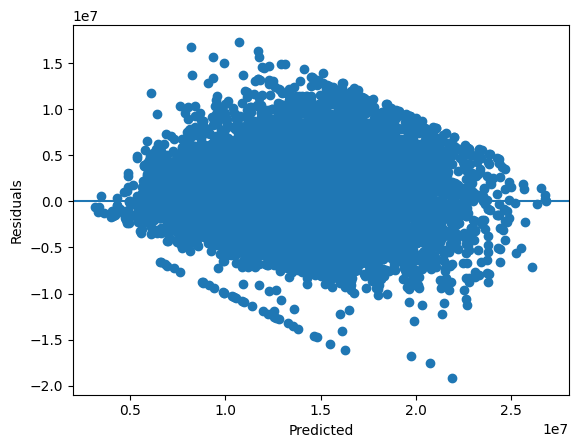

In [18]:
plt.scatter(predictions, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [19]:
pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(X_test, predictions)
input_example = X_test[:10]

/home/mle-user/mle_projects/mle-project-sprint-2/.venv_sprint_2/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


In [21]:
params = {}
params["target_col"] = "price"
params["test_size"] = 0.2


In [23]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_registry_uri("http://127.0.0.1:5000")

In [29]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.environ.get("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.environ.get("AWS_SECRET_ACCESS_KEY")

In [31]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [32]:
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run = run.info.run_id
    mlflow.log_metrics(metrics)
    mlflow.log_params(params)
    model_info = mlflow.sklearn.log_model(sk_model=pipeline, artifact_path="models",
                                          registered_model_name=REGISTRY_MODEL_NAME,
                                          await_registration_for=60,
                                          pip_requirements=pip_requirements,
                                          signature=signature,
                                          input_example=input_example)

Successfully registered model 'Registered_Linear_model'.
2026/01/29 03:28:53 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: Registered_Linear_model, version 1
Created version '1' of model 'Registered_Linear_model'.
